The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.0-alpha1.post0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 606 kB/s 
     |████████████████████████████████| 120 kB 61.1 MB/s 
     |████████████████████████████████| 1.6 MB 53.9 MB/s 
     |████████████████████████████████| 82 kB 600 kB/s 


# Concise Implementation for Multiple GPUs
:label:`sec_multi_gpu_concise`

Implementing parallelism from scratch for every new model is no fun. Moreover, there is significant benefit in optimizing synchronization tools for high performance. In the following we will show how to do this using high-level APIs of deep learning frameworks.
The mathematics and the algorithms are the same as in :numref:`sec_multi_gpu`.
Quite unsurprisingly you will need at least two GPUs to run code of this section.


In [2]:
import torch
from torch import nn
from d2l import torch as d2l

## [**A Toy Network**]

Let's use a slightly more meaningful network than LeNet from :numref:`sec_multi_gpu` that is still sufficiently easy and quick to train.
We pick a ResNet-18 variant :cite:`He.Zhang.Ren.ea.2016`. Since the input images are tiny we modify it slightly. In particular, the difference from :numref:`sec_resnet` is that we use a smaller convolution kernel, stride, and padding at the beginning.
Moreover, we remove the max-pooling layer.


In [3]:
#@save
def resnet18(num_classes, in_channels=1):
    """A slightly modified ResNet-18 model."""
    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(d2l.Residual(out_channels, use_1x1conv=True,
                                        strides=2))
            else:
                blk.append(d2l.Residual(out_channels))
        return nn.Sequential(*blk)

    # This model uses a smaller convolution kernel, stride, and padding and
    # removes the max-pooling layer
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(),
                                       nn.Linear(512, num_classes)))
    return net

## Network Initialization


We will initialize the network inside the training loop.
For a refresher on initialization methods see :numref:`sec_numerical_stability`.


In [4]:
net = resnet18(10)
# Get a list of GPUs
devices = d2l.try_all_gpus()
# We will initialize the network inside the training loop

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## [**Training**]

As before, the training code needs to perform several basic functions for efficient parallelism:

* Network parameters need to be initialized across all devices.
* While iterating over the dataset minibatches are to be divided across all devices.
* We compute the loss and its gradient in parallel across devices.
* Gradients are aggregated and parameters are updated accordingly.

In the end we compute the accuracy (again in parallel) to report the final performance of the network. The training routine is quite similar to implementations in previous chapters, except that we need to split and aggregate data.


In [5]:
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    def init_weights(module):
        if type(module) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(module.weight, std=0.01)
    net.apply(init_weights)
    # Set the model on multiple GPUs
    net = nn.DataParallel(net, device_ids=devices)
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')

Let's see how this works in practice. As a warm-up we [**train the network on a single GPU.**]


test acc: 0.91, 43.1 sec/epoch on [device(type='cuda', index=0)]


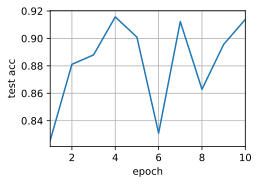

In [6]:
train(net, num_gpus=1, batch_size=256, lr=0.1)

Next we [**use 2 GPUs for training**]. Compared with LeNet
evaluated in :numref:`sec_multi_gpu`,
the model for ResNet-18 is considerably more complex. This is where parallelization shows its advantage. The time for computation is meaningfully larger than the time for synchronizing parameters. This improves scalability since the overhead for parallelization is less relevant.


In [7]:
# train(net, num_gpus=2, batch_size=512, lr=0.2)

## Summary


* Data is automatically evaluated on the devices where the data can be found.
* Take care to initialize the networks on each device before trying to access the parameters on that device. Otherwise you will encounter an error.
* The optimization algorithms automatically aggregate over multiple GPUs.



## Exercises


1. This section uses ResNet-18. Try different epochs, batch sizes, and learning rates. Use more GPUs for computation. What happens if you try this with 16 GPUs (e.g., on an AWS p2.16xlarge instance)?
1. Sometimes, different devices provide different computing power. We could use the GPUs and the CPU at the same time. How should we divide the work? Is it worth the effort? Why? Why not?


[Discussions](https://discuss.d2l.ai/t/1403)
